In [1]:
from dataloader.dataloader import DatasetLoader

from functions.calculate_mse_psnr import calculate_mse_psnr

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
import copy
from torchvision import transforms
from torch.optim.lr_scheduler import StepLR, MultiStepLR, ExponentialLR, ReduceLROnPlateau


from PIL import Image

import numpy as np

import matplotlib.pyplot as plt

import os
import scipy.io
from tqdm import tqdm
from models.CSModelPlus import CSModelPlus


In [2]:
device = "cpu"
transform = transforms.Compose([ # Ajusta al tamaño deseado
    transforms.ToTensor()
])

wts = torch.load("./train_results/CSDecoder/25000_0.0001_1000_0.8/best_model.pth")
phi = torch.load("./train_results/CSDecoder/25000_0.0001_1000_0.8/phi_epoch.pt")

model = CSModelPlus(output_size=256,CR=0.1,phi=phi,pretrained_weights=wts,device=device).to(device)
model.eval()


CSModelPlus(
  (layer1): Linear(in_features=25, out_features=512, bias=True)
  (layer2): Linear(in_features=512, out_features=512, bias=True)
  (layer3): Linear(in_features=512, out_features=512, bias=True)
  (layer4): Linear(in_features=512, out_features=256, bias=True)
)

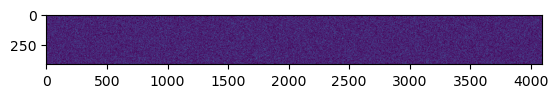

In [7]:
phi = np.array(phi)

plt.imshow(phi*255)

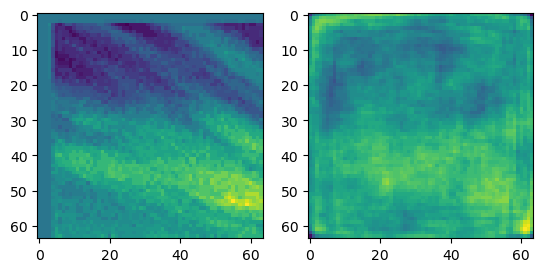

In [10]:
transform = transforms.Compose([ # Ajusta al tamaño deseado
    transforms.ToTensor()
])
nKernel = 64
parche = Image.open(f"./dataset/parches64/1parche1.png").convert("L")
parchet = transform(parche).to(device)

model.eval()

with torch.no_grad():
    parche_rec = model(parchet.view(1,1,-1)).cpu().squeeze().reshape(nKernel,nKernel)
    
parche_rec = (np.array(parche_rec)*255.0).astype(np.uint8)
parche_rec = Image.fromarray(parche_rec)

plt.subplot(1,2,1)
plt.imshow(parche)


plt.subplot(1,2,2)

plt.imshow(parche_rec)
plt.show()

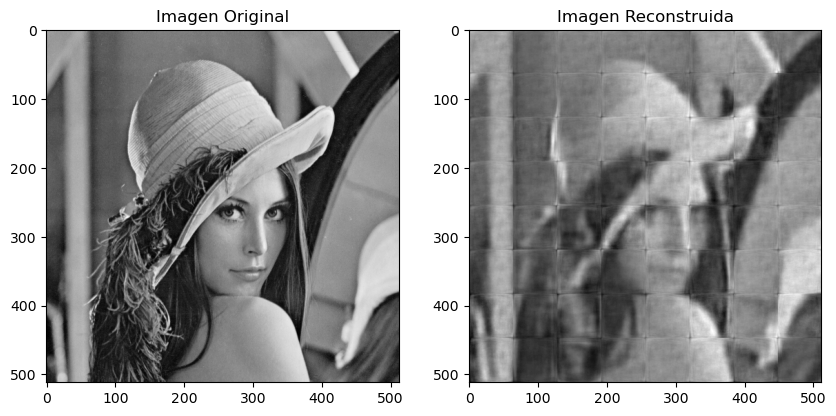

MSE : 270.80493545532227 || PSNR : 23.804237857090143


In [16]:
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import torch

imageOG = Image.open("./dataset/standard_Images/Lenna.png").convert("L")
transform = transforms.Compose([
    transforms.ToTensor(),
])
image = transform(imageOG)
patch_size = nKernel
num_patches_height = image.shape[1] // patch_size
num_patches_width = image.shape[2] // patch_size
reconstructed_image = torch.zeros((patch_size * num_patches_height, patch_size * num_patches_width))
all_inputs = []
for i in range(num_patches_height):
    for j in range(num_patches_width):
        patch = image[:, i * patch_size:(i + 1) * patch_size, j * patch_size:(j + 1) * patch_size]
        patch = patch.to(device).reshape(1, -1)
        input = patch
        all_inputs.append(input)
        with torch.no_grad():
            model.eval()
            patch_rec = torch.clamp(model(input).cpu().squeeze(),max=1,min=0)
        reconstructed_image[i * patch_size:(i + 1) * patch_size, j * patch_size:(j + 1) * patch_size] = patch_rec.reshape(patch_size, patch_size)
all_inputs_tensor = torch.stack(all_inputs)
reconstructed_image = (reconstructed_image * 255.0).clamp(0, 255).numpy().astype(np.uint8)
reconstructed_image = Image.fromarray(reconstructed_image)
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(imageOG, cmap='gray')
plt.title('Imagen Original')
plt.subplot(1, 2, 2)
plt.imshow(reconstructed_image, cmap='gray')
plt.title('Imagen Reconstruida')
plt.show()
mse,psnr = calculate_mse_psnr(imageOG,reconstructed_image)
print(f"MSE : {mse} || PSNR : {psnr}")


In [15]:
reconstructed_image.save("Lennafea.png")